# Deep Q-Network (DQN)
---
In this notebook, you will implement a DQN agent with OpenAI Gym's LunarLander-v2 environment.

### 1. Import the Necessary Packages

In [2]:
import gym
!pip3 install box2d
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

!python -m pip install pyvirtualdisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from collections import namedtuple, deque

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 2. Explore the environment

Initialize the environment in the code cell below.

In [4]:
env = gym.make('LunarLander-v2')
env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
State shape:  (8,)
Number of actions:  4


In [56]:
env.action_space.sample()

3

In [5]:
STATE_SIZE = 8
ACTION_SIZE = 4

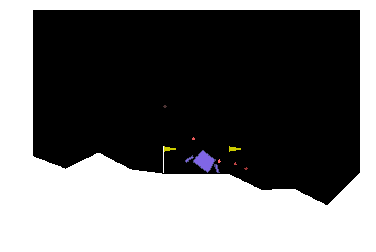

In [3]:
img = plt.imshow(env.render(mode='rgb_array'))
state = env.reset()
for j in range(200):
    action = env.action_space.sample() 
    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, _ = env.step(action)
    if done:
        break 
env.close()

### 3. Replay buffer

In [179]:
buffer = deque(maxlen = 500)  
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
state = env.reset()
for j in range(200):
    action = env.action_space.sample() 
    next_state, reward, done, _ = env.step(action)
    buffer.append(experience(state, action, reward, next_state, done))
    state = next_state
    if done:
        break 
env.close()

In [6]:
class ReplayBuffer(object):
    def __init__(self, buffer_size) :
        self.memory = deque(maxlen = buffer_size)  
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

    def add(self, state, action, reward, next_state, done):
        x = self.experience(state, action, reward, next_state, done)
        self.memory.append(x)

    def sample(self, batch_size):
        samples = random.sample(self.memory, k = batch_size)
        batch = self.experience(*zip(*samples))
        states = torch.from_numpy(np.asarray(batch.state)).float().to(device)
        actions = torch.from_numpy(np.asarray(batch.action)).long().view(-1,1).to(device) # discrete action space
        rewards = torch.from_numpy(np.asarray(batch.reward)).float().view(-1,1).to(device)
        next_states = torch.tensor(np.asarray(batch.next_state)).float().to(device)
        # 0 for note finished, 1 for terminated
        dones = torch.tensor([1 if done else 0 for done in batch.done]).float().view(-1,1).to(device)
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.memory)


In [206]:
memory = ReplayBuffer(buffer_size = 500)

state = env.reset()
for j in range(200):
    action = env.action_space.sample() 
    next_state, reward, done, _ = env.step(action)
    memory.add(state, action, reward, next_state, done)
    state = next_state
    if done:
        break 
env.close()

In [207]:
print(len(memory))

77


In [209]:
states, actions, rewards, next_states, dones = memory.sample(16)
print(states.size())
print(actions.size())
print(rewards.size())
print(dones.size())

torch.Size([16, 8])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])


### 4. Q network

In [7]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_size, seed):
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.main = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(inplace = True),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(inplace = True),
            nn.Linear(hidden_size, action_size)
        )
        
    def forward(self, state):
        x = self.main(state)
        return x

In [212]:
net = QNetwork(STATE_SIZE, ACTION_SIZE, 16,1234).to(device)

### 5. Build agent

wrap:

1) act: select action according to policy derived from online network

2) learn: take a GD step

3) soft_update: update target network

4) step: (overall control)add tuple to replay buffer, sample a batch from buffer to learn (call learn)



In [8]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 0.999             # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the target network


class Agent():
    def __init__(self, state_size, action_size, hidden_size, seed):
        
        self.state_size = state_size
        self.action_size = action_size
        self.hidden_size = hidden_size
        self.seed = seed
        
        self.online_net = QNetwork(state_size, action_size, hidden_size, seed).to(device)
        self.target_net = QNetwork(state_size, action_size, hidden_size, seed).to(device)
        
        self.optimizer = optim.Adam(self.online_net.parameters(), lr = LR)
        self.memory = ReplayBuffer(buffer_size = BUFFER_SIZE)
        self.t_step = 1 # tracking whether to update target network parameters
        
    def act(self, state, eps = 0.):
        state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)
        # select action according to online network
        self.online_net.eval()
        with torch.no_grad():
            action = self.online_net(state_tensor).argmax(1).item()
        self.online_net.train()
        
        # Epsilon-greedy action selection
        if random.random() > eps:
            return action
        else:
            return random.choice(np.arange(self.action_size))
        
    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences
        loss_fn = nn.MSELoss()

        next_Q = self.target_net(next_states).max(1)[0].unsqueeze(1)
        target = rewards + gamma*next_Q*(1-dones)
        
        prediction = self.online_net(states).gather(1, actions)
        
        loss = loss_fn(prediction, target.detach())
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def soft_update(self, tau):
        for target_param, online_param in zip(self.target_net.parameters(), self.online_net.parameters()):
            target_param.data.copy_(tau*target_param.data + (1.0-tau)*online_param.data)
        
        
    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        self.t_step = self.t_step + 1
        
        # update target network
        if (self.t_step % UPDATE_EVERY) == 0:
            self.soft_update(TAU)
            
        # sample batch and learn
        if len(self.memory)> BATCH_SIZE: 
            experiences = self.memory.sample(BATCH_SIZE)
            self.learn(experiences, GAMMA)
            
        

In [221]:
agent = Agent(STATE_SIZE, ACTION_SIZE, 16,1234)

In [222]:
state = env.reset()
state

array([ 0.00507536,  0.93736935,  0.51406441, -0.21628388, -0.00587429,
       -0.11644325,  0.        ,  0.        ])

In [223]:
agent.act(state)

3

In [224]:
state = env.reset()
for j in range(200):
    action = agent.act(state)
    next_state, reward, done, _ = env.step(action)
    agent.step(state, action, reward, next_state, done)
    state = next_state
    if done:
        break 
env.close()

In [225]:
len(agent.memory) 

56

In [226]:
agent.t_step

56

### 6. train agent

put all the pieces together, and start training

In [239]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 0.999             # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the target network
TMAX = 1000             # maximum steps per episode

n_episodes = 800
eps_start = 1.0
eps_end = 0.01
eps_decay = 0.995

PRINT_EVERY = 50

agent = Agent(STATE_SIZE, ACTION_SIZE, 64,1234)

In [240]:
scores = []; score_window = deque(maxlen = PRINT_EVERY)                        
eps = eps_start                    
hold_mean = 0.0

for i_episode in range(1, n_episodes+1):
    state = env.reset()
    score = 0
    for t in range(TMAX):
        action = agent.act(state, eps)
        next_state, reward, done, _ = env.step(action)
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        if done:
            break 
    eps = max(eps_end, eps_decay*eps) # decrease epsilon
            
    scores.append(score)    
    score_window.append(score)
    mean_score = np.mean(score_window)
    
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, mean_score), end="")
    if i_episode % PRINT_EVERY == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode,mean_score))
    if mean_score >=hold_mean:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, mean_score))
        torch.save(agent.online_net.state_dict(), 'checkpoint.pth')
        hold_mean = mean_score

Episode 50	Average Score: -210.01
Episode 100	Average Score: -183.71
Episode 150	Average Score: -196.72
Episode 200	Average Score: -142.83
Episode 250	Average Score: -121.70
Episode 300	Average Score: -75.331
Episode 350	Average Score: -29.57
Episode 400	Average Score: -45.10
Episode 437	Average Score: 2.0432
Environment solved in 337 episodes!	Average Score: 2.04
Episode 438	Average Score: 4.15
Environment solved in 338 episodes!	Average Score: 4.15
Episode 441	Average Score: 7.22
Environment solved in 341 episodes!	Average Score: 7.22
Episode 442	Average Score: 8.68
Environment solved in 342 episodes!	Average Score: 8.68
Episode 443	Average Score: 14.21
Environment solved in 343 episodes!	Average Score: 14.21
Episode 444	Average Score: 19.87
Environment solved in 344 episodes!	Average Score: 19.87
Episode 445	Average Score: 24.49
Environment solved in 345 episodes!	Average Score: 24.49
Episode 446	Average Score: 26.08
Environment solved in 346 episodes!	Average Score: 26.08
Episode 4

Episode 605	Average Score: 182.89
Environment solved in 505 episodes!	Average Score: 182.89
Episode 606	Average Score: 183.18
Environment solved in 506 episodes!	Average Score: 183.18
Episode 607	Average Score: 184.23
Environment solved in 507 episodes!	Average Score: 184.23
Episode 608	Average Score: 184.78
Environment solved in 508 episodes!	Average Score: 184.78
Episode 611	Average Score: 184.99
Environment solved in 511 episodes!	Average Score: 184.99
Episode 616	Average Score: 185.41
Environment solved in 516 episodes!	Average Score: 185.41
Episode 618	Average Score: 188.74
Environment solved in 518 episodes!	Average Score: 188.74
Episode 619	Average Score: 189.39
Environment solved in 519 episodes!	Average Score: 189.39
Episode 620	Average Score: 189.48
Environment solved in 520 episodes!	Average Score: 189.48
Episode 623	Average Score: 191.47
Environment solved in 523 episodes!	Average Score: 191.47
Episode 625	Average Score: 191.56
Environment solved in 525 episodes!	Average Sc

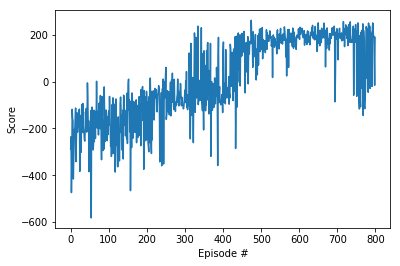

In [241]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 4. Watch a Smart Agent!

In the next code cell, you will load the trained weights from file to watch a smart agent!

In [10]:
# load the weights from file
agent = Agent(STATE_SIZE, ACTION_SIZE, 64,1234)
agent.online_net.load_state_dict(torch.load('checkpoint.pth'))

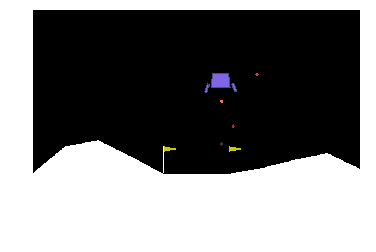

In [ ]:
for i in range(3):
    state = env.reset()
    img = plt.imshow(env.render(mode='rgb_array'))
    for j in range(200):
        action = agent.act(state)
        img.set_data(env.render(mode='rgb_array')) 
        plt.axis('off')
        display.display(plt.gcf())
        display.clear_output(wait=True)
        state, reward, done, _ = env.step(action)
        if done:
            break 
            
env.close()

### 5. Explore

In this exercise, you have implemented a DQN agent and demonstrated how to use it to solve an OpenAI Gym environment.  To continue your learning, you are encouraged to complete any (or all!) of the following tasks:
- Amend the various hyperparameters and network architecture to see if you can get your agent to solve the environment faster.  Once you build intuition for the hyperparameters that work well with this environment, try solving a different OpenAI Gym task with discrete actions!
- You may like to implement some improvements such as prioritized experience replay, Double DQN, or Dueling DQN! 
- Write a blog post explaining the intuition behind the DQN algorithm and demonstrating how to use it to solve an RL environment of your choosing.  